In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
cardio = pd.read_csv('dataset.csv')

In [3]:
#Check any null values
cardio.isnull().any()

Gender                    False
Age                       False
Height(cm)                False
Weight(kg)                False
Family_history            False
Alcohol                   False
Junk_food                 False
Vege_day                  False
Meals_day                 False
Snack                     False
Smoking                   False
Water_intake(L)           False
Transportation            False
Exercise                  False
TV                        False
Income                    False
Discipline                False
Cardiovascular_risk(y)    False
dtype: bool

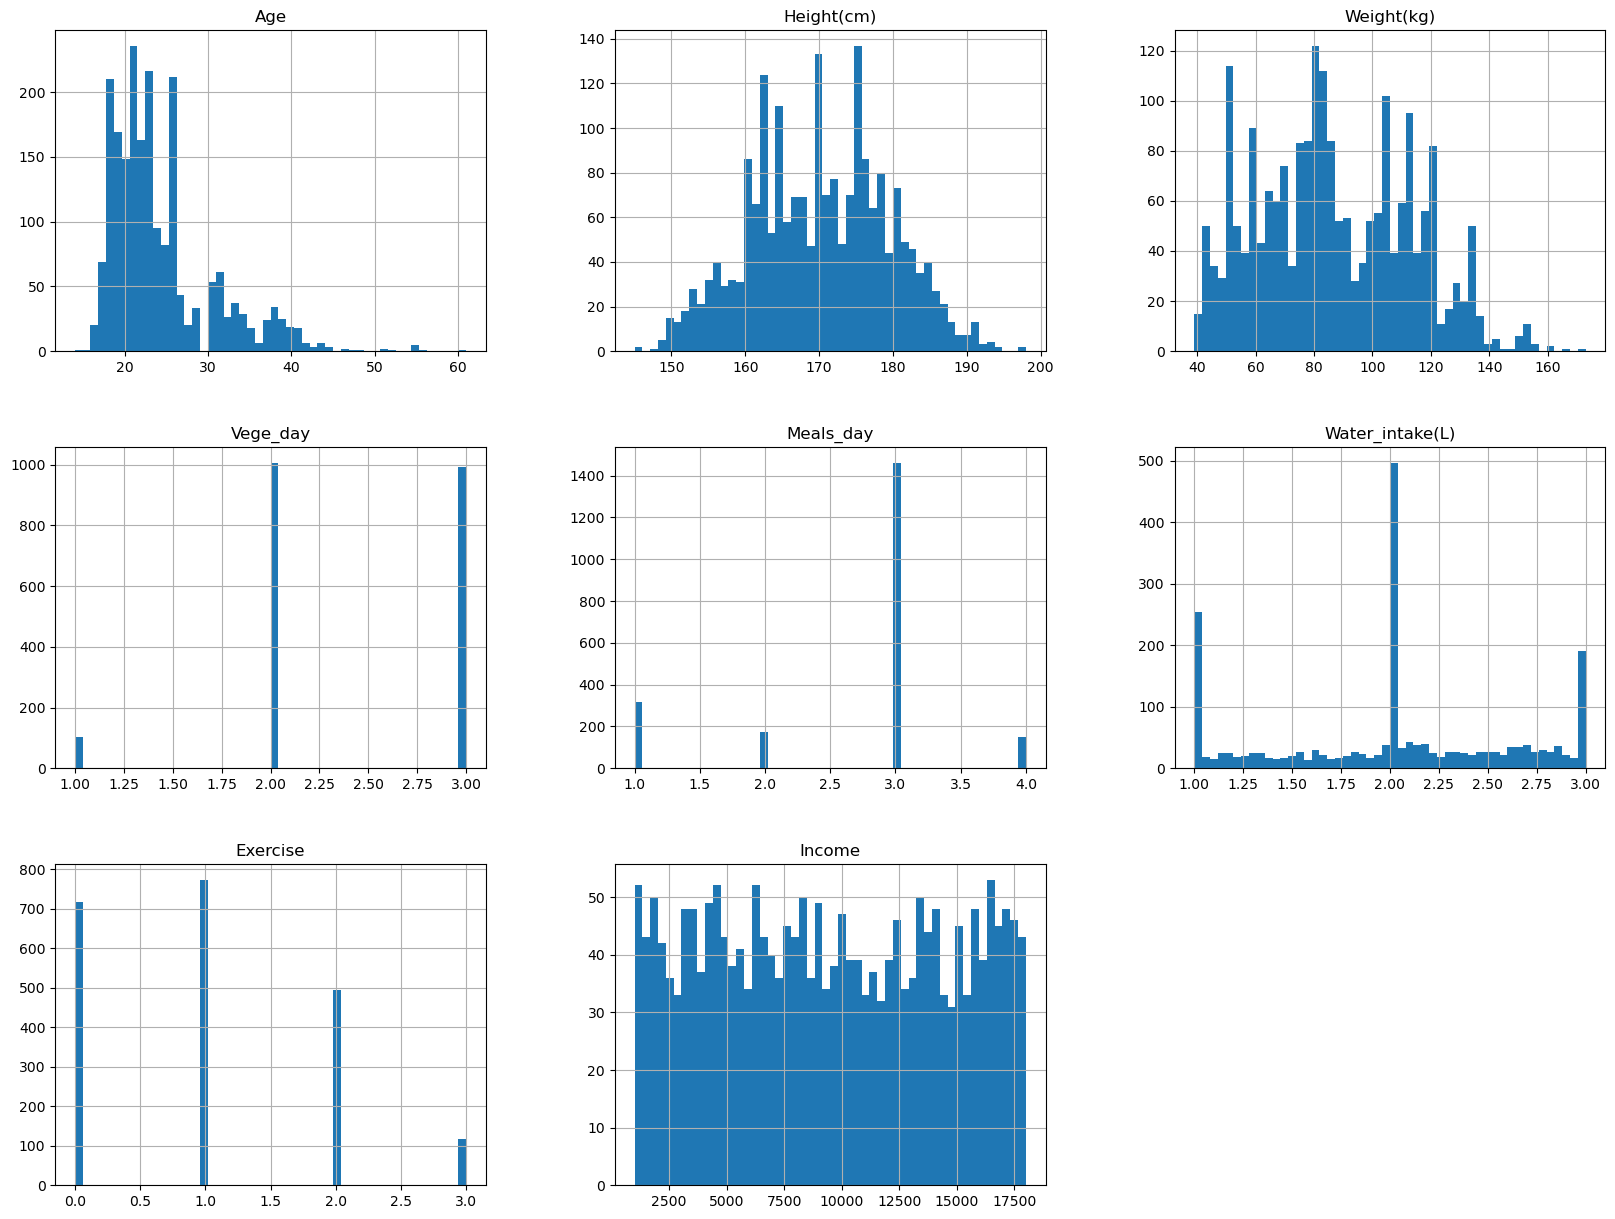

In [4]:
cardio.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
#Data preprocessing

# Separate the output vector from the input matrix
X = cardio.drop(['Cardiovascular_risk(y)'], axis=1)
y = cardio['Cardiovascular_risk(y)']

print ('X: shape=', X.shape, 'type=', type(X))
print ('y: shape=', y.shape, 'type=', type(y))

#Extract height,weight feature -> BMI
X = X.drop(['Height(cm)','Weight(kg)'],axis=1)

height = cardio['Height(cm)']
weight = cardio['Weight(kg)']

height = height/100 # convert cm to m
bmi = weight/ height**2

X = pd.concat([X, bmi.rename('BMI')], axis=1)

# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ('full set shape=', X.shape)
print ('train shape=', X_train.shape)
print ('test shape=', X_test.shape)

# Split the input matrix into numerical and categorical sets
X_train_num = X_train.drop(['Gender','Family_history','Alcohol','Junk_food','Snack','Smoking','Transportation','TV','Discipline'], axis = 1)
X_gender = X_train['Gender']
X_fam = X_train['Family_history']
X_alcohol = X_train['Alcohol']
X_junk = X_train['Junk_food']
X_snack = X_train['Snack']
X_smoke = X_train['Smoking']
X_transport = X_train['Transportation']
X_tv = X_train['TV']
X_discipline = X_train['Discipline']

#standardization numeric data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy = False)
scaler.fit(X_train_num)       
X_train_num_tr = scaler.transform(X_train_num)

print('>>> Mean of all columns:\n', X_train_num_tr.mean(axis=0))
print('\n>>> Std of all columns:\n', X_train_num_tr.std(axis=0))

#one hot encoding - gender,fam, junk,smoking, transport,discipline
from sklearn.preprocessing import LabelBinarizer

gender_encoder = LabelBinarizer()
fam_encoder = LabelBinarizer()
junk_encoder = LabelBinarizer()
smoke_encoder = LabelBinarizer()
discipline_encoder = LabelBinarizer()
transport_encoder = LabelBinarizer()

X_gender_tr = gender_encoder.fit_transform(X_gender) 
X_fam_tr = fam_encoder.fit_transform(X_fam)
X_junk_tr = junk_encoder.fit_transform(X_junk)
X_smoke_tr = smoke_encoder.fit_transform(X_smoke)
X_discipline_tr = discipline_encoder.fit_transform(X_discipline)
X_transport_tr = transport_encoder.fit_transform(X_transport)

#label encoding - alcohol, snack,tv
from sklearn.preprocessing import LabelEncoder

alcohol_encoder = LabelEncoder()
label_mapping = {'none': 0, 'low': 1, 'medium': 2, 'high': 3}
alcohol_encoder.classes_ = [k for k in label_mapping.keys()]
X_alcohol_tr = alcohol_encoder.fit_transform([label_mapping[label] for label in X_alcohol])

snack_encoder = LabelEncoder()
label_mapping = {'No': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
snack_encoder.classes_ = [k for k in label_mapping.keys()]
X_snack_tr = snack_encoder.fit_transform([label_mapping[label] for label in X_snack])

tv_encoder = LabelEncoder()
label_mapping = {'rare': 0, 'moderate': 1, 'often': 2}
tv_encoder.classes_ = [k for k in label_mapping.keys()]
X_tv_tr = tv_encoder.fit_transform([label_mapping[label] for label in X_tv])


#Finalize training set
X_alcohol_tr = X_alcohol_tr.reshape(-1, 1)
X_snack_tr = X_snack_tr.reshape(-1, 1)
X_tv_tr = X_tv_tr.reshape(-1, 1)
X_train_tr = np.hstack([X_train_num_tr, X_gender_tr, X_fam_tr, X_junk_tr,X_smoke_tr, X_transport_tr, X_discipline_tr,
                        X_alcohol_tr, X_snack_tr, X_tv_tr])

print('X_train_tr shape:', X_train_tr.shape)

X: shape= (2100, 17) type= <class 'pandas.core.frame.DataFrame'>
y: shape= (2100,) type= <class 'pandas.core.series.Series'>
full set shape= (2100, 16)
train shape= (1680, 16)
test shape= (420, 16)
>>> Mean of all columns:
 [-1.69176842e-17  6.34413157e-18 -2.64338815e-16  3.93336157e-16
  1.69969858e-16  1.50144447e-16 -5.03301104e-16]

>>> Std of all columns:
 [1. 1. 1. 1. 1. 1. 1.]
X_train_tr shape: (1680, 20)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [7]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Fit the model on the training data
log_reg.fit(X_train_tr, y_train)

# Predict on the train set to check the performance
y_pred_cv = cross_val_predict (log_reg, X_train_tr, y_train, cv=3)


In [8]:
#visualising confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix with labels\n\n'):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    
    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(3,3)
    
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['High','Low','Medium'])
    ax.yaxis.set_ticklabels(['High','Low','Medium'])
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()

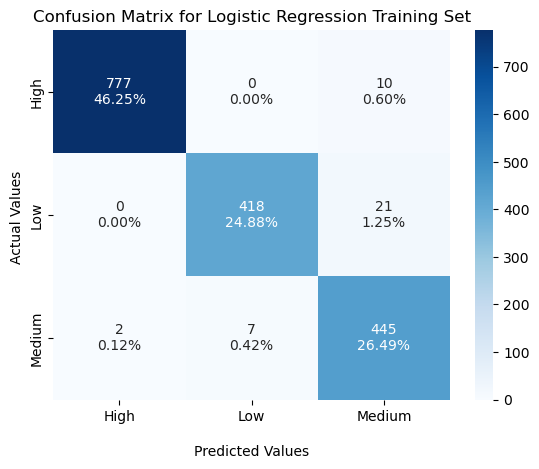

In [9]:
#Confusion matrix
cm = confusion_matrix (y_train, y_pred_cv)
#print(cm)
plot_confusion_matrix(cm, 'Confusion Matrix for Logistic Regression Training Set')

In [10]:
#Classification report
class_report = classification_report(y_train, y_pred_cv)

print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        high       1.00      0.99      0.99       787
         low       0.98      0.95      0.97       439
      medium       0.93      0.98      0.96       454

    accuracy                           0.98      1680
   macro avg       0.97      0.97      0.97      1680
weighted avg       0.98      0.98      0.98      1680



In [11]:
from sklearn.metrics import precision_recall_curve # plot PR curve

# Function to plot Precision-Recall curves for each class
def plot_pr_curves(y_true, y_scores, class_labels):
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(class_labels):
        precision, recall, _ = precision_recall_curve(y_true == label, y_scores[:, i])
        plt.plot(recall, precision, label=f'Class {label}')

    # Add diagonal baseline line
    plt.plot(np.linspace(0, 1, 20), np.linspace(1, 0, 20), 'k--')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Graph')
    plt.legend(loc='best')
    plt.grid(True)
    plt.axis([0, 1, 0, 1])  # Ensure axis limits cover the range
    plt.show()




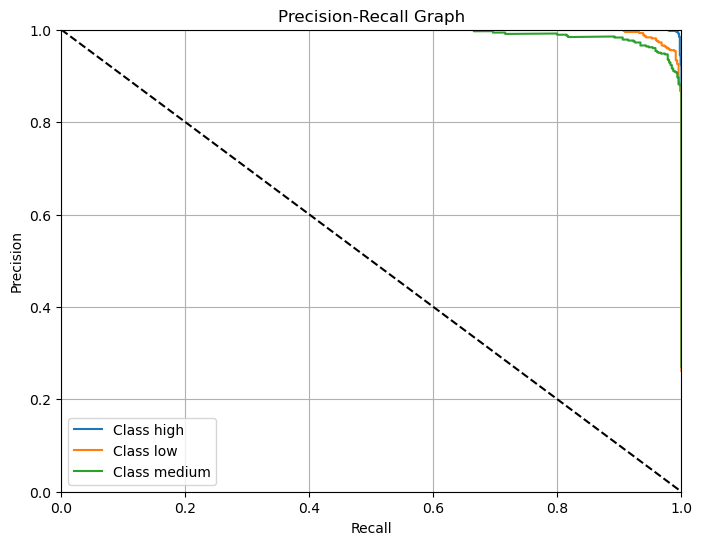

In [12]:
# Example usage with cross-validated predictions
y_scores_cv = cross_val_predict(log_reg, X_train_tr, y_train, cv=3, method='predict_proba')
class_labels = np.unique(y_train)

plot_pr_curves(y_train, y_scores_cv, class_labels)

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc(model):
    # Get the class names from the model
    class_names = model.classes_
    
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
    
    # Predict probabilities for all classes
    y_scores = model.predict_proba(X_train_tr)
    
    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve and ROC AUC
    fpr["macro"], tpr["macro"], _ = roc_curve(y_train_bin.ravel(), y_scores.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each class
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))
    
    # Plot macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"], color='m', lw=2, label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
    
    # Plot diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()




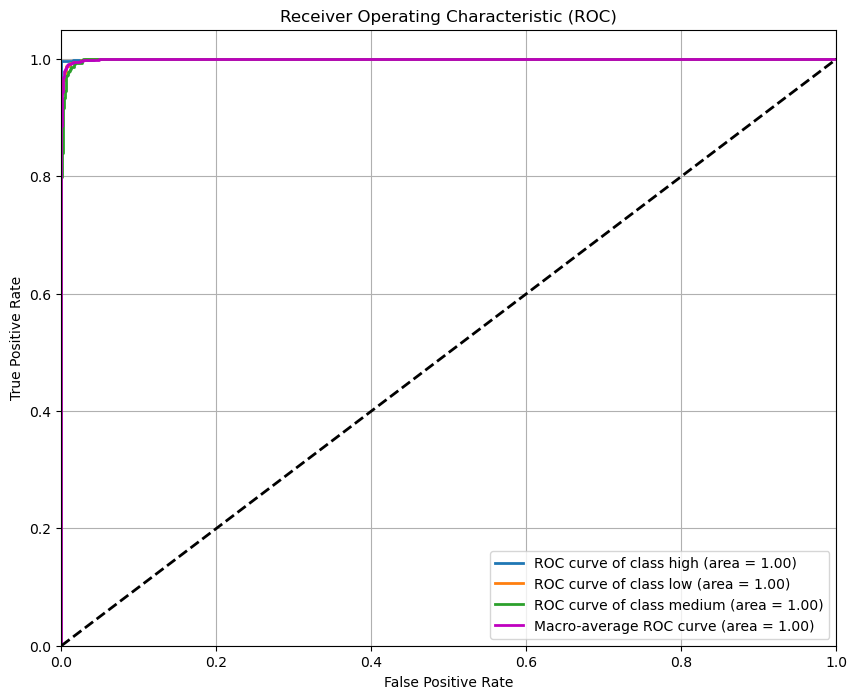

In [14]:
plot_roc(log_reg)

In [15]:
#preprocess test set
X_test_num = X_test.drop(['Gender','Family_history','Alcohol','Junk_food','Snack','Smoking','Transportation','TV','Discipline'], axis = 1)

X_gender_test = X_test['Gender']
X_fam_test = X_test['Family_history']
X_alcohol_test = X_test['Alcohol']
X_junk_test = X_test['Junk_food']
X_snack_test = X_test['Snack']
X_smoke_test = X_test['Smoking']
X_transport_test = X_test['Transportation']
X_tv_test = X_test['TV']
X_discipline_test = X_test['Discipline']

X_test_num_tr = scaler.transform(X_test_num)

X_gender_test_tr = gender_encoder.transform(X_gender_test) 
X_fam_test_tr = fam_encoder.transform(X_fam_test)
X_junk_test_tr = junk_encoder.transform(X_junk_test)
X_smoke_test_tr = smoke_encoder.transform(X_smoke_test)
X_transport_test_tr = transport_encoder.transform(X_transport_test)
X_discipline_test_tr = discipline_encoder.transform(X_discipline_test)


label_mapping = {'none': 0, 'low': 1, 'medium': 2, 'high': 3}
X_alcohol_test_tr = np.array([label_mapping[label] for label in X_alcohol_test])

label_mapping = {'No': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
X_snack_test_tr = np.array([label_mapping[label] for label in X_snack_test])

label_mapping = {'rare': 0, 'moderate': 1, 'often': 2}
X_tv_test_tr = np.array([label_mapping[label] for label in X_tv_test])

X_alcohol_test_tr = X_alcohol_test_tr.reshape(-1, 1)
X_snack_test_tr = X_snack_test_tr.reshape(-1, 1)
X_tv_test_tr = X_tv_test_tr.reshape(-1, 1)
X_test_tr = np.hstack([X_test_num_tr, X_gender_test_tr, X_fam_test_tr, X_junk_test_tr,X_smoke_test_tr, X_transport_test_tr, 
                       X_discipline_test_tr, X_alcohol_test_tr, X_snack_test_tr, X_tv_test_tr])

print('X_test_tr shape:', X_test_tr.shape)

X_test_tr shape: (420, 20)


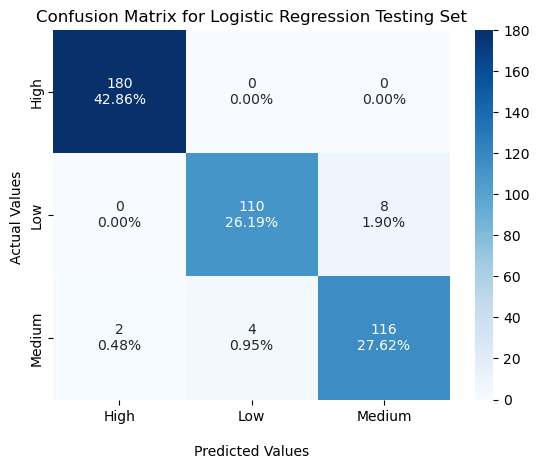

In [16]:
# predict on test set
y_pred_test = log_reg.predict(X_test_tr) 

cm = confusion_matrix (y_test, y_pred_test)
plot_confusion_matrix(cm, 'Confusion Matrix for Logistic Regression Testing Set')

In [17]:
class_report = classification_report(y_test, y_pred_test)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        high       0.99      1.00      0.99       180
         low       0.96      0.93      0.95       118
      medium       0.94      0.95      0.94       122

    accuracy                           0.97       420
   macro avg       0.96      0.96      0.96       420
weighted avg       0.97      0.97      0.97       420



In [18]:
#fine tune the model by grid searching
logistic_reg = LogisticRegression(random_state=42)

#some solvers in LogisticRegression does not support all types of penalties
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs', 'newton-cg', 'sag'], 'max_iter': [100, 500, 1000, 2000]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear','saga'], 'max_iter': [100, 500, 1000, 2000]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['elasticnet'], 'solver': ['saga'],'l1_ratio': [0.5, 0.7, 0.9], 'max_iter': [100, 500, 1000,2000]}
]

#perform grid search, n_jobs for parallel processing
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
print ('Performing grid search...', end = '')
grid_search.fit(X_train_tr, y_train)
print('done')

Performing grid search...done


E:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [19]:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=1, max_iter=500, penalty='l1', random_state=42,
                   solver='saga')

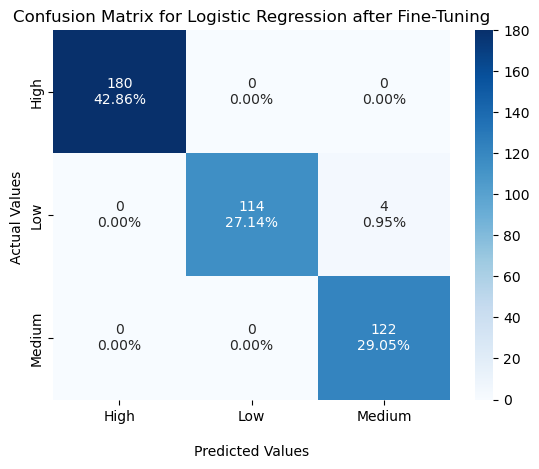

In [20]:
# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test_tr)
cm = confusion_matrix (y_test, y_pred_test)
plot_confusion_matrix(cm, 'Confusion Matrix for Logistic Regression after Fine-Tuning')

In [21]:
#classification report
class_report = classification_report(y_test, y_pred_test)
class_report_dict = classification_report(y_test, y_pred_test, output_dict=True)
macro_precision =  class_report_dict['macro avg']['precision'] 
macro_recall = class_report_dict['macro avg']['recall']    
macro_f1 = class_report_dict['macro avg']['f1-score']
accuracy = class_report_dict['accuracy']

print(class_report)

              precision    recall  f1-score   support

        high       1.00      1.00      1.00       180
         low       1.00      0.97      0.98       118
      medium       0.97      1.00      0.98       122

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



In [22]:
#insight on important data (logistic regression)
feature_importances = best_model.coef_[0]

attributes = (X_train_num.columns.tolist() 
              + list(gender_encoder.classes_)
              + ['fam_' + value for value in fam_encoder.classes_]
              + ['junk_' + value for value in junk_encoder.classes_]
              + ['smoke_' + value for value in smoke_encoder.classes_]
              + ['discipline_' + value for value in discipline_encoder.classes_]
              + list(transport_encoder  .classes_)
             )

sorted(zip(feature_importances, attributes), reverse=True)

[(23.428770179990106, 'BMI'),
 (0.9443941771116007, 'fam_no'),
 (0.2142483540178877, 'bicycle'),
 (0.0, 'smoke_yes'),
 (0.0, 'smoke_no'),
 (0.0, 'junk_yes'),
 (0.0, 'junk_no'),
 (0.0, 'fam_yes'),
 (0.0, 'discipline_yes'),
 (0.0, 'discipline_no'),
 (0.0, 'car'),
 (0.0, 'bus'),
 (0.0, 'Water_intake(L)'),
 (0.0, 'Vege_day'),
 (0.0, 'Male'),
 (0.0, 'Income'),
 (0.0, 'Age'),
 (-0.014392718041790277, 'Exercise'),
 (-0.09518981282511269, 'Meals_day'),
 (-0.6153182075214575, 'Female')]

In [23]:
#Initialize the K Nearest Neighbour Model
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)

#Fit the model on the training data
knn.fit(X_train_tr,y_train)

#Predict on the training set 
y_pred_k = knn.predict(X_train_tr)


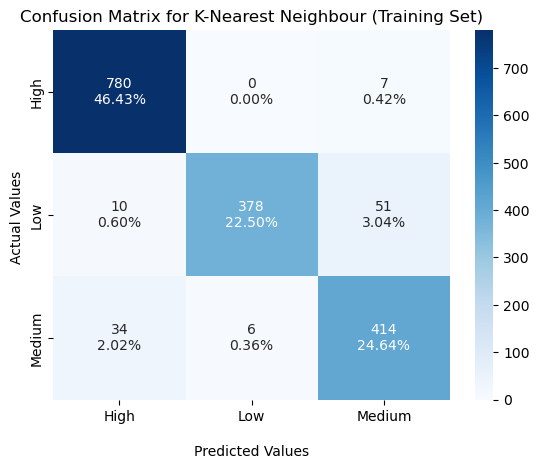

In [24]:
#Confusion Matrix for training set
cmk= confusion_matrix (y_train, y_pred_k)
plot_confusion_matrix(cmk, 'Confusion Matrix for K-Nearest Neighbour (Training Set)')

In [25]:
#Classification report for training set
class_report_k= classification_report(y_train, y_pred_k)
print('Classification Report (k nearest neighbour:')
print(class_report_k)

Classification Report (k nearest neighbour:
              precision    recall  f1-score   support

        high       0.95      0.99      0.97       787
         low       0.98      0.86      0.92       439
      medium       0.88      0.91      0.89       454

    accuracy                           0.94      1680
   macro avg       0.94      0.92      0.93      1680
weighted avg       0.94      0.94      0.94      1680



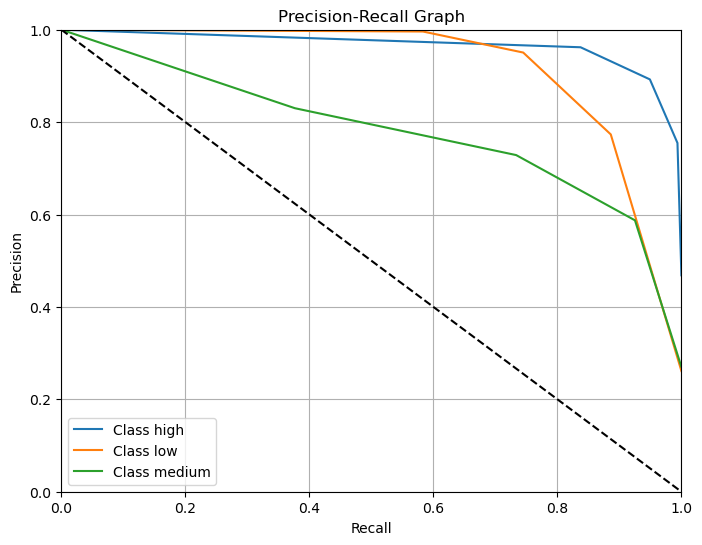

In [26]:
# Example usage with cross-validated predictions
y_scores_cv = cross_val_predict(knn, X_train_tr, y_train, cv=3, method='predict_proba')
class_labels = np.unique(y_train)

plot_pr_curves(y_train, y_scores_cv, class_labels)

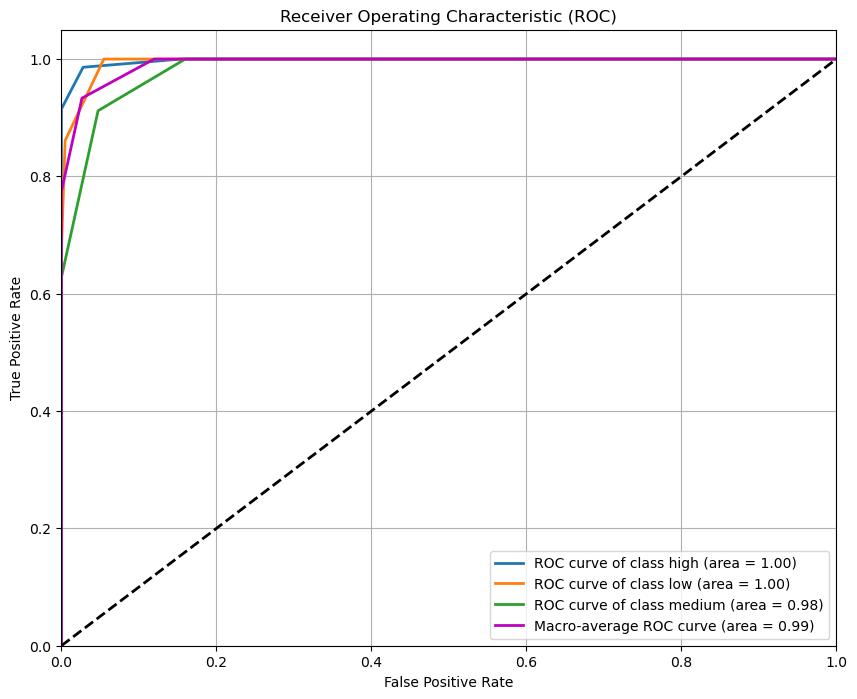

In [27]:
plot_roc(knn)

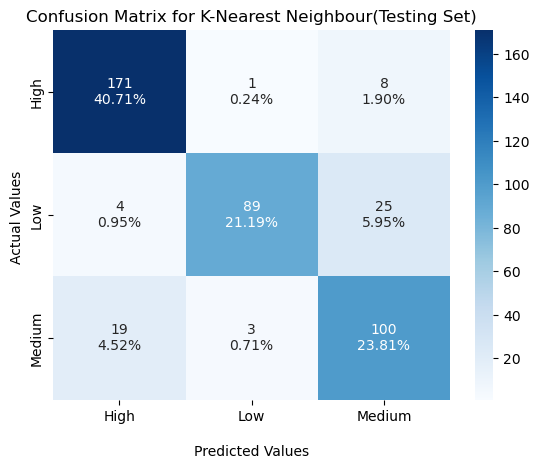

In [28]:
#predict on test set (k nearest neighbour)
y_pred_test_k=knn.predict(X_test_tr)

#Confusion matrix for test set
cmk = confusion_matrix (y_test, y_pred_test_k)
plot_confusion_matrix(cmk, 'Confusion Matrix for K-Nearest Neighbour(Testing Set)')

In [29]:
#classification report for test set
class_report_k=classification_report(y_test, y_pred_test_k)
print('Classification Report (K nearest neighbour:)')
print(class_report_k)

Classification Report (K nearest neighbour:)
              precision    recall  f1-score   support

        high       0.88      0.95      0.91       180
         low       0.96      0.75      0.84       118
      medium       0.75      0.82      0.78       122

    accuracy                           0.86       420
   macro avg       0.86      0.84      0.85       420
weighted avg       0.87      0.86      0.86       420



In [30]:
#fine tune the model by grid searching (k nearest neighbour)
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],          
    'weights': ['uniform', 'distance'],       
    'metric': ['euclidean','manhattan','minkowski'],     
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'leaf_size': [10, 20, 30, 40, 50],
    'p':[1,2,3,4,5] 
}
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

print('Performing grid search...', end='')
grid_search.fit(X_train_tr, y_train)
print('done')


Performing grid search...Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
done


E:\Anaconda\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.84642857 0.85       0.84642857 ... 0.81904762        nan 0.80952381]
  warnings.warn(


In [31]:
#Find best model
best_model = grid_search.best_estimator_
best_model

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=9, p=1,
                     weights='distance')

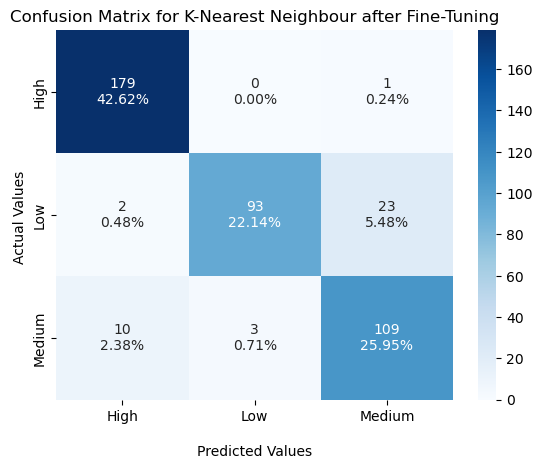

In [32]:
#Evluate the best model on test set (k nearest neighbour)
y_pred_test_k = best_model.predict(X_test_tr)

#confusion matrix for best model
cmk = confusion_matrix (y_test, y_pred_test_k)
plot_confusion_matrix(cmk, 'Confusion Matrix for K-Nearest Neighbour after Fine-Tuning')

In [33]:
#classification report for best model
class_report = classification_report(y_test, y_pred_test_k)
class_report_dict = classification_report(y_test, y_pred_test_k, output_dict=True)
macro_precision =  class_report_dict['macro avg']['precision'] 
macro_recall = class_report_dict['macro avg']['recall']    
macro_f1 = class_report_dict['macro avg']['f1-score']
accuracy = class_report_dict['accuracy']

print(class_report)

              precision    recall  f1-score   support

        high       0.94      0.99      0.96       180
         low       0.97      0.79      0.87       118
      medium       0.82      0.89      0.85       122

    accuracy                           0.91       420
   macro avg       0.91      0.89      0.90       420
weighted avg       0.91      0.91      0.91       420



In [34]:
#insight on important data (K Nearest Neighbour)
from sklearn.inspection import permutation_importance

result = permutation_importance(grid_search.best_estimator_, X_test_tr, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature importances and corresponding attributes
feature_importances = result.importances_mean
attributes = (X_train_num.columns.tolist() 
              + list(gender_encoder.classes_)
              + ['fam_' + value for value in fam_encoder.classes_]
              + ['junk_' + value for value in junk_encoder.classes_]
              + ['smoke_' + value for value in smoke_encoder.classes_]
              + ['discipline_' + value for value in discipline_encoder.classes_]
              + list(transport_encoder.classes_)
             )

# Sort and display feature importances
sorted_importances = sorted(zip(feature_importances, attributes), reverse=True)
for importance, attribute in sorted_importances:
    print(f"{attribute}: {importance}")

BMI: 0.24952380952380954
car: 0.036904761904761885
Age: 0.03476190476190476
Meals_day: 0.026190476190476198
Male: 0.024523809523809538
Water_intake(L): 0.02404761904761906
Vege_day: 0.023571428571428577
Exercise: 0.023333333333333338
bus: 0.017380952380952407
Female: 0.017142857142857137
fam_no: 0.0161904761904762
bicycle: 0.013809523809523827
Income: 0.006428571428571428
discipline_yes: 0.00523809523809522
smoke_yes: 0.0023809523809523725
junk_no: 0.0
fam_yes: 0.0
discipline_no: -0.002857142857142847
smoke_no: -0.00428571428571427
junk_yes: -0.006904761904761881


In [35]:
# Kenji
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

forest_clf = RandomForestClassifier(n_estimators = 10, random_state = 42)

forest_clf.fit(X_train_tr, y_train)

y_pred_forest = forest_clf.predict(X_train_tr)

forest_cm = confusion_matrix (y_train, y_pred_forest)

forest_cm

array([[787,   0,   0],
       [  0, 439,   0],
       [  1,   0, 453]], dtype=int64)

In [36]:
forest_class_report = classification_report(y_train, y_pred_forest)
print(forest_class_report)

              precision    recall  f1-score   support

        high       1.00      1.00      1.00       787
         low       1.00      1.00      1.00       439
      medium       1.00      1.00      1.00       454

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680



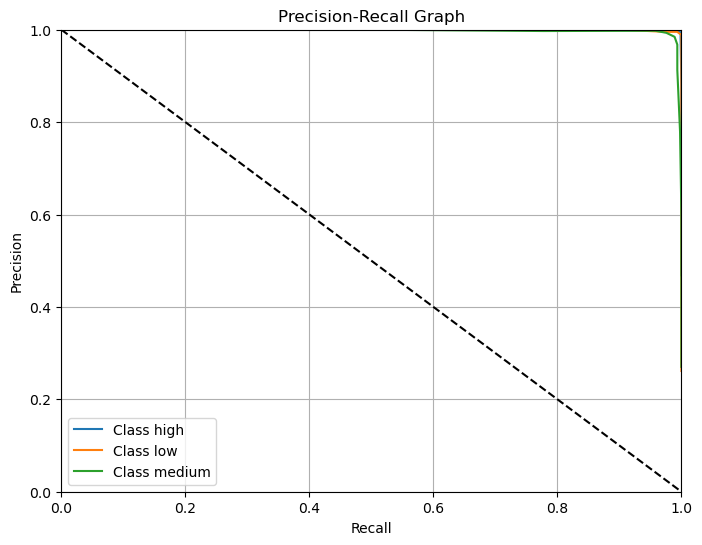

In [37]:
# Example usage with cross-validated predictions
y_scores_cv = cross_val_predict(forest_clf, X_train_tr, y_train, cv=3, method='predict_proba')
class_labels = np.unique(y_train)

plot_pr_curves(y_train, y_scores_cv, class_labels)

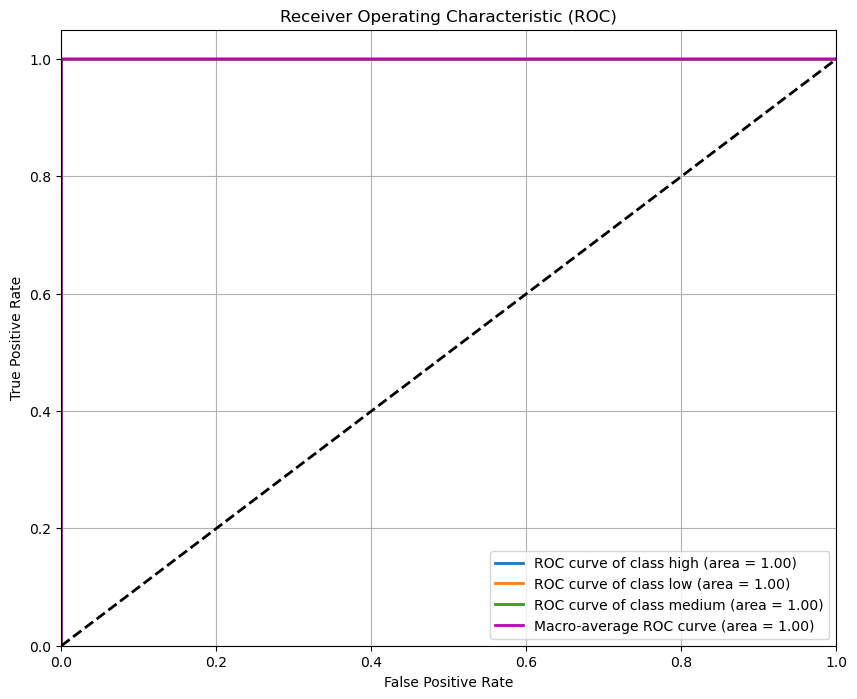

In [38]:
plot_roc(forest_clf)

In [39]:
y_pred_test_forest = forest_clf.predict(X_test_tr) 

forest_test_cm = confusion_matrix (y_test, y_pred_test_forest)

forest_test_cm

array([[180,   0,   0],
       [  0, 118,   0],
       [  1,   1, 120]], dtype=int64)

In [40]:
forest_class_report_test = classification_report(y_test, y_pred_test_forest)
print(forest_class_report_test)

              precision    recall  f1-score   support

        high       0.99      1.00      1.00       180
         low       0.99      1.00      1.00       118
      medium       1.00      0.98      0.99       122

    accuracy                           1.00       420
   macro avg       1.00      0.99      0.99       420
weighted avg       1.00      1.00      1.00       420



In [41]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    #'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)] (previous code)
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=400, num=10)],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform randomized search with 100 iterations and 5-fold cross-validation
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')

# Fit the randomized search to the data
random_search.fit(X_train_tr, y_train)

# Best hyperparameters found
best_params = random_search.best_params_

# Train the model with the best parameters on the full training set
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_tr, y_train)

# Predict on the test set
y_pred_best_rf = best_rf.predict(X_test_tr)

# Evaluate the model
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_class_report = classification_report(y_test, y_pred_best_rf)

# Output the best parameters, accuracy, and classification report
print(best_params)
print(best_rf_accuracy)
print(best_rf_class_report)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'n_estimators': 288, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
1.0
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       180
         low       1.00      1.00      1.00       118
      medium       1.00      1.00      1.00       122

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



In [42]:
forest_cm = confusion_matrix(y_test, y_pred_best_rf)
forest_cm

array([[180,   0,   0],
       [  0, 118,   0],
       [  0,   0, 122]], dtype=int64)

In [43]:
# Assuming grid_search is your GridSearchCV or RandomizedSearchCV object
feature_importances = best_rf.feature_importances_

attributes = (X_train_num.columns.tolist() 
              + list(gender_encoder.classes_)
              + ['fam_' + value for value in fam_encoder.classes_]
              + ['junk_' + value for value in junk_encoder.classes_]
              + ['smoke_' + value for value in smoke_encoder.classes_]
              + ['discipline_' + value for value in discipline_encoder.classes_]
              + list(transport_encoder.classes_)
             )

sorted_features = sorted(zip(feature_importances, attributes), reverse=True)

# Output the sorted feature importances and their corresponding attributes
for importance, attribute in sorted_features:
    print(f"{attribute}: {importance}")


BMI: 0.6388143860921014
Male: 0.07007277405399043
bus: 0.06263940780939034
Age: 0.06239222350645168
Water_intake(L): 0.026260455165588472
Meals_day: 0.021879759993125403
fam_no: 0.018998598037180472
bicycle: 0.012620927638222161
Vege_day: 0.012521161422162213
Exercise: 0.011047022879361173
Income: 0.010303711583089797
discipline_yes: 0.009957291992647955
Female: 0.009670690191396455
smoke_no: 0.009491840752665397
junk_yes: 0.009356424786745064
car: 0.008809581888740306
discipline_no: 0.002825707965978199
fam_yes: 0.001553347618102712
smoke_yes: 0.0005281721321861069
junk_no: 0.00025651449087414185
